In [1]:
import re
import numpy as np
import pandas as pd
from pprint import pprint
from nltk import tokenize
from nltk import word_tokenize
# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import nltk
# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel/pylab/backend_inline.py:164: DeprecationWarning: `configure_inline_support` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.configure_inline_support()`
  configure_inline_support(ip, backend)


In [2]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

In [3]:
data=pd.read_csv('Detection_Violence_Dataset.csv')


# Convert to list

In [4]:
# Convert to list
data =data.Text.values.tolist()


In [5]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['they', 'chant', 'death', 'america', 'plead', 'new', 'administration', 'raise', 'classification', 'terrorists', 'they', 'steal', 'food', 'mouths', 'hungry', 'tell', 'world', 'starvation', 'yemen', 'they', 'kill', 'yemenis', 'blow', 'homes', 'recruiy']]


# Build the bigram and trigram models

In [6]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['they', 'chant', 'death', 'america', 'plead_new_administration', 'raise', 'classification', 'terrorists', 'they', 'steal', 'food', 'mouths', 'hungry_tell', 'world', 'starvation', 'yemen', 'they', 'kill', 'yemenis', 'blow', 'homes', 'recruiy']


In [8]:

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

# Do lemmatization keeping only noun, adj, vb, adv

In [9]:
# Remove Stop Words
data_words_nostops =  data_words

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['chant', 'death', 'america', 'plead_new', 'administration', 'raise', 'classification', 'terrorist', 'steal', 'food', 'mouth', 'hungry', 'tell', 'world', 'starvation', 'yeman', 'kill', 'yemenis', 'blow', 'home', 'recruiy']]


# Create Dictionary, Corpus Term and Document Frequency

In [10]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)
# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1)]]


In [11]:
id2word[0]

'administration'

# LDA Model

In [12]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=10, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=50,
                                           alpha='auto',
                                           per_word_topics=True)

In [13]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.106*"child" + 0.090*"kill" + 0.064*"recruit" + 0.044*"thousand" + '
  '0.041*"home" + 0.040*"houthi" + 0.038*"mine" + 0.037*"woman" + '
  '0.032*"yemeni" + 0.031*"militia"'),
 (1,
  '0.077*"house" + 0.039*"tweet" + 0.035*"movement" + 0.034*"work" + '
  '0.032*"may" + 0.029*"would" + 0.026*"sanaa" + 0.024*"say" + 0.024*"worship" '
  '+ 0.024*"houthis"'),
 (2,
  '0.129*"organization" + 0.045*"houthi" + 0.041*"militia" + 0.039*"many" + '
  '0.037*"face" + 0.034*"old" + 0.033*"terrorist" + 0.033*"citizen" + '
  '0.029*"know" + 0.025*"back"'),
 (3,
  '0.045*"family" + 0.038*"believe" + 0.037*"houthis" + 0.037*"front" + '
  '0.029*"mean" + 0.028*"weapon" + 0.028*"innocent" + 0.025*"violate" + '
  '0.024*"medium" + 0.024*"kid"'),
 (4,
  '0.102*"yemeni" + 0.091*"houthis" + 0.085*"people" + 0.048*"war" + '
  '0.042*"right" + 0.035*"force" + 0.022*"racist" + 0.021*"nazi" + '
  '0.020*"population" + 0.018*"taiz"'),
 (5,
  '0.053*"year" + 0.033*"city" + 0.027*"girl" + 0.026*"houthis" + '

# Compute Perplexity

In [14]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -6.9172375005531865

Coherence Score:  0.3277628389383222


# Visualize the topics-keywords

In [173]:
'''pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis'''

'pyLDAvis.enable_notebook()\nvis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)\nvis'

# Improve LDA wrapper by Mallet Model

In [16]:
mallet_path = 'mallet-2.0.8/bin/mallet' # update this path
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=10, id2word=id2word)

# Compute Coherence Score

In [17]:
# Show Topics
#pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)


Coherence Score:  0.33089618770702484


# compute Coherence values

In [18]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=1, step=2):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [19]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=1, limit=10, step=2)


In [20]:
optimal_model = model_list[4]
optimal_model.show_topic(0)

[('yeman', 0.08177770696690477),
 ('houthi', 0.06985492622392168),
 ('yemeni', 0.052152207971534026),
 ('terrorism', 0.047655717535427564),
 ('house', 0.02398718323198527),
 ('life', 0.022765695672570523),
 ('control', 0.02072103171441975),
 ('result', 0.018738327270152334),
 ('region', 0.01653433884773007),
 ('face', 0.016242243996565674)]

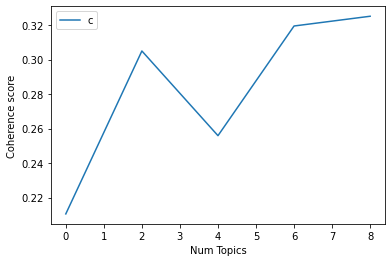

In [21]:
# Show graph
limit=10; start=0; step=2;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [22]:
print(coherence_values)

[0.2105639896580787, 0.3049681066369004, 0.2559020724034521, 0.31943977844735577, 0.32508870903110176]


In [23]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 2))

Num Topics = 0  has Coherence Value of 0.21
Num Topics = 2  has Coherence Value of 0.3
Num Topics = 4  has Coherence Value of 0.26
Num Topics = 6  has Coherence Value of 0.32
Num Topics = 8  has Coherence Value of 0.33


In [24]:
optimal_model = model_list[4]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.082*"yeman" + 0.070*"houthi" + 0.052*"yemeni" + 0.048*"terrorism" + '
  '0.024*"house" + 0.023*"life" + 0.021*"control" + 0.019*"result" + '
  '0.017*"region" + 0.016*"face"'),
 (1,
  '0.140*"child" + 0.063*"recruit" + 0.049*"mine" + 0.039*"home" + '
  '0.030*"kill" + 0.027*"aid" + 0.026*"plant" + 0.025*"blow" + 0.025*"family" '
  '+ 0.021*"yemeni"'),
 (2,
  '0.157*"houthis" + 0.055*"death" + 0.054*"crime" + 0.029*"terrorist" + '
  '0.023*"commit" + 0.022*"slogan" + 0.021*"america" + 0.018*"movement" + '
  '0.014*"people" + 0.013*"friend"'),
 (3,
  '0.144*"group" + 0.088*"terrorist" + 0.071*"houthi" + 0.040*"ansar" + '
  '0.039*"allah" + 0.033*"yeman" + 0.029*"nazi" + 0.027*"racist" + '
  '0.024*"human" + 0.023*"peace"'),
 (4,
  '0.079*"houthi" + 0.059*"kill" + 0.050*"militia" + 0.040*"woman" + '
  '0.038*"thousand" + 0.023*"prison" + 0.020*"journalist" + 0.019*"torture" + '
  '0.019*"year" + 0.019*"kidnap"'),
 (5,
  '0.159*"houthi" + 0.111*"militia" + 0.029*"freedom" + 0.027

# Select Dominant_topic_ids

In [25]:
def getDominantTopics():
        # get topic weight matrix using lda.inference
        # the matrix has dimensions (num documents) x (num topics)
        inference = lda_model.inference(corpus)
        inference = inference[0] # the inference is a tuple, need the first term
        num_topics = lda_model.num_topics
        num_dominant_topics=5

        # find dominant topics across documents (vertical sum)
        column_sum_of_weights = np.sum(inference, axis=0)
        sorted_weight_indices = np.argsort(column_sum_of_weights)
        idx = np.arange(num_topics - num_dominant_topics, num_topics)
        dominant_topic_ids = sorted_weight_indices[idx]
        # the dominant_topic_ids store the ids in descending order of dominance
        dominant_topic_ids = dominant_topic_ids[::-1]
        
#        print(dominant_topic_ids)
        return dominant_topic_ids.tolist()
    
dominant_topic_ids=getDominantTopics()
dominant_topic_ids

[7, 4, 8, 0, 6]

# Select top_terms for Dominant_topic

In [26]:
def topic_term():
    token=[]
    for ki in dominant_topic_ids:
        topic_terms =ldamallet.show_topic(ki)
        terms = [t[0] for t in topic_terms]
        weights = [w[1] for w in topic_terms]
#        print ('The top {:d} terms and corresponding weights are:'.format(ki))
#        for term, weight in zip(terms, weights):
        for term in terms:
            token.append(term)
#            print ('  {:s} ({:5.4f})'.format(term, weight))
    return token
top_terms=topic_term()


# Documents Classification based on  Dominant_topic 

In [27]:
import operator
filtered_by_topic_id=[]
def get_high_w(distributions):
    dic={}
    for k, distribution in enumerate(distributions):
        filtered = [d for d in distribution]
        if filtered[0] in dominant_topic_ids:  
            dic.update({filtered[0]:filtered[1]})
    sorted_x = sorted(dic.items(), key=operator.itemgetter(1))
    return sorted_x[-1]
   

In [ ]:
from nltk import word_tokenize
import operator
Data_classification=pd.DataFrame()
sent_topics_df = pd.DataFrame()
get_document_topics = lda_model.get_document_topics
for sentences in data:
    tkns = word_tokenize(sentences)
    bow = id2word.doc2bow(tkns)
    distributions=get_document_topics(bow)
    doc=get_high_w(distributions)
    topic_terms=ldamallet.show_topic(doc[0])
    terms = [t[0] for t in topic_terms]
    Data_classification=Data_classification.append(pd.Series([int(doc[0]), sentences]), ignore_index=True)
    sent_topics_df = sent_topics_df.append(pd.Series([int(doc[0]), round(doc[1],6), terms, sentences]), ignore_index=True)



# Create Dataset 

In [32]:
Data_classification.columns = ['Dominant_Topic', 'Text']



In [33]:
sent_topics_df.columns = ['Dominant_Topic','Topic_Perc_Contrib','Topic_Term', 'Text']


In [34]:
Data_classification.to_csv('Data_Classification_full.csv')

In [35]:
sent_topics_df.to_csv('LDA_Data_full.csv')